This notebook demonstrates how to reconstruct the x position of hits using the output of GEMC using two different methods, and compares them to the truth level.  The first method uses the difference in time from the TDCs on either side, exploiting the fact that the signal-propagation time along a scintillator bar to the SiPMs at either end depends on the hit position.  The second uses the log of the ratio of the ADC values on either side, exploiting the attenuation of signal along the bar.  Finally we combine the results of the two recon methods.

In [1]:
import uproot,scipy,time
import numpy as np, pandas as pd, awkward as ak
from scipy.constants import golden
import matplotlib as mpl, matplotlib.patches as patches, matplotlib.pylab as plt



#presets for plot style
plt.rcParams["figure.figsize"] = [7.00, 3.50]
plt.rcParams["figure.autolayout"] = True
rc = plt.rc

rc('text', usetex=False)

rc('font', family='serif')
rc('font', size=18)

rc('xtick', labelsize=18)
rc('ytick', labelsize=18)

rc('axes', labelsize=18)
rc('legend', fontsize=18)

plt.rcParams['figure.facecolor']='white'
plt.rcParams['savefig.facecolor']='white'
plt.rcParams['savefig.bbox']='tight'

def findindex(xvals,xval): 
    minima = 66e6
    for i,elem in enumerate(xvals):
        # Update minimum difference from xval and index of the minimum difference
        if abs(xval-elem) < minima: 
            minima = abs(xval-elem) 
            index = i
    return index

def findmax(xvals,yvals,xmin,xmax): 
    xminindex = -666
    xmaxindex = -666
    # Find the indexes of the limits using findindex function
    xminindex = findindex(xvals,xmin)
    xmaxindex = findindex(xvals,xmax)
    # Find the max y value and the x value which is at the same index
    maxy = max(yvals[xminindex:xmaxindex])
    maxx = xvals[np.where(yvals==maxy)[0][0]]
    #maxx = 0
    return maxx,maxy #return peak as x,y coordinate tuple

def SetLandau():
    global LandauXs
    global LandauYs
    lookuptable = np.loadtxt("landaulookuptable.txt",float)
    LandauXs = lookuptable[:,0]
    LandauYs = lookuptable[:,-1]
    return
SetLandau()

def Landau(x, location,fwhm,renormalization):
    #print(type(x))
    u=(x-location)*4/fwhm
    renormalization = 8/5*renormalization
    return renormalization * np.exp(-u/2 - np.exp(-u)/2)

def Landau2(xs,location,fwhm,renormalization):
    if "array" in str(type(xs)) or "list" in str(type(xs)):
        linapprox=[]
        for x in xs:
            u=(x-location)/fwhm
            if u < -3.8 or u > 500: linapp = 0
            else:
                for i in range(len(LandauXs)):
                    if LandauXs[i] < u: index = i
                    else: break
                linapp = renormalization*(u-LandauXs[index])*(LandauYs[index+1]-LandauYs[index])/(LandauXs[index+1]-LandauXs[index])+renormalization*LandauYs[index]
            linapprox.append(linapp)
    else:
        u=(xs-location)/fwhm
        if u < -3.8 or u > 500: linapprox = 0
        else:
            for i in range(len(LandauXs)):
                if LandauXs[i] < u: index = i
                else: break

            linapprox = renormalization*(u-LandauXs[index])*(LandauYs[index+1]-LandauYs[index])/(LandauXs[index+1]-LandauXs[index])+renormalization*LandauYs[index]
    return linapprox

### Create the Awkward Arrays from the ROOT tree

In [2]:
f=uproot.open("../out_muons.root")

#fcal1=f["fcal;1"]

fcal=f["fcal"]
print(fcal.keys())
generated=f["generated"]
header = f["header"]

['sector', 'layer', 'component', 'ADC_order', 'ADC_ADC', 'ADC_time', 'ADC_ped', 'TDC_order', 'TDC_TDC', 'hitn', 'pid', 'mpid', 'tid', 'mtid', 'otid', 'trackE', 'totEdep', 'avg_x', 'avg_y', 'avg_z', 'avg_lx', 'avg_ly', 'avg_lz', 'px', 'py', 'pz', 'vx', 'vy', 'vz', 'mvx', 'mvy', 'mvz', 'avg_t', 'nsteps', 'procID']


In [ ]:
#puts all branches as named arrays in single variable
#keys = fcal.keys()
#branches = fcal.arrays()

In [3]:
fADC_ord = fcal["ADC_order"].array()

flayer = fcal["layer"].array()
layers = flayer[fADC_ord == 0]

fcomponent = fcal["component"].array()
components = fcomponent[fADC_ord == 0]

fADC_time = fcal["ADC_time"].array()
ADCR_times = fADC_time[fADC_ord == 0]
ADCL_times = fADC_time[fADC_ord == 1]

fADC_ADC = fcal["ADC_ADC"].array()
ADCR_vals = fADC_ADC[fADC_ord == 0]
ADCL_vals = fADC_ADC[fADC_ord == 1]

fTDC_TDC = fcal["TDC_TDC"].array()
TDCR_vals = fTDC_TDC[fADC_ord == 0]
TDCL_vals = fTDC_TDC[fADC_ord == 1]

ftotEdep = fcal["totEdep"].array()
Edeps = ftotEdep[fADC_ord == 0]

favgx = fcal["avg_x"].array()
avg_xs = favgx[fADC_ord == 0]

favgy = fcal["avg_y"].array()
avg_ys = favgy[fADC_ord == 0]

favgz = fcal["avg_z"].array()
avg_zs = favgz[fADC_ord == 0]

favgt = fcal["avg_t"].array()
avg_ts = favgt[fADC_ord == 0]

gpx = generated["px"].array()
gpy = generated["py"].array()
gpz = generated["pz"].array()
eventn = header["evn"].array()

In [4]:
#remove events with zero hits
event_hits = ak.count(layers,-1)
hitscut = event_hits > 0

layers = layers[hitscut]
components = components[hitscut]
ADCR_times = ADCR_times[hitscut]
ADCL_times = ADCL_times[hitscut]
ADCR_vals = ADCR_vals[hitscut]
ADCL_vals = ADCL_vals[hitscut]
TDCR_vals = TDCR_vals[hitscut]
TDCL_vals = TDCL_vals[hitscut]
Edeps = Edeps[hitscut]
avg_xs = avg_xs[hitscut]
avg_ys = avg_ys[hitscut]
avg_zs = avg_zs[hitscut]
avg_ts = avg_ts[hitscut]

gpx = gpx[hitscut]
gpy = gpy[hitscut]
gpz = gpz[hitscut]
eventn = eventn[hitscut]

### Determine where to set low energy cut (MIPcut) to filter "junk" hits:

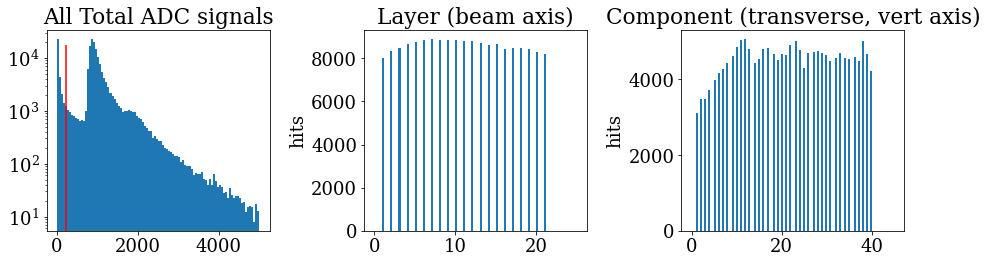

In [5]:
MIP = 876.4
minGeoMean=MIP/4
MIPcut = np.sqrt(ADCR_vals*ADCL_vals) > minGeoMean

fig,ax = plt.subplots(1,3,figsize=(13,4))
ax[0].set_title("All Total ADC signals")
ax[0].hist(np.sqrt(ak.flatten(ADCR_vals)*ak.flatten(ADCL_vals)),bins=100,range=(0,5000),log=1)
ax[0].vlines(minGeoMean,ymin=0,ymax=17500, color='r')
ax[1].set_title("Layer (beam axis)")
ax[1].set_ylabel("hits")
ax[1].hist(ak.flatten(layers),bins=100,range=(0,25))
ax[2].set_title("Component (transverse, vert axis)")
ax[2].set_ylabel("hits")
ax[2].hist(ak.flatten(components),bins=100,range=(0,45))
plt.show()

### Analyze energy deposition per event

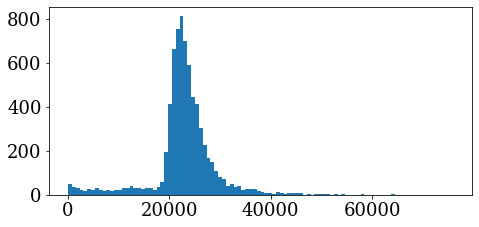

Time: 0.27


In [1]:
toc = time.perf_counter()
ADCs = np.sqrt(ADCR_vals[MIPcut]*ADCL_vals[MIPcut])
totADC = ak.sum(np.sqrt(ADCR_vals[MIPcut]*ADCL_vals[MIPcut]),-1)
totEdep = ak.sum(np.sqrt(Edeps[MIPcut]*Edeps[MIPcut]),-1)



#cut = fADC_time < 100 & 
tic = time.perf_counter()
print(f"Time: {tic-toc:.2f}")


NameError: name 'time' is not defined

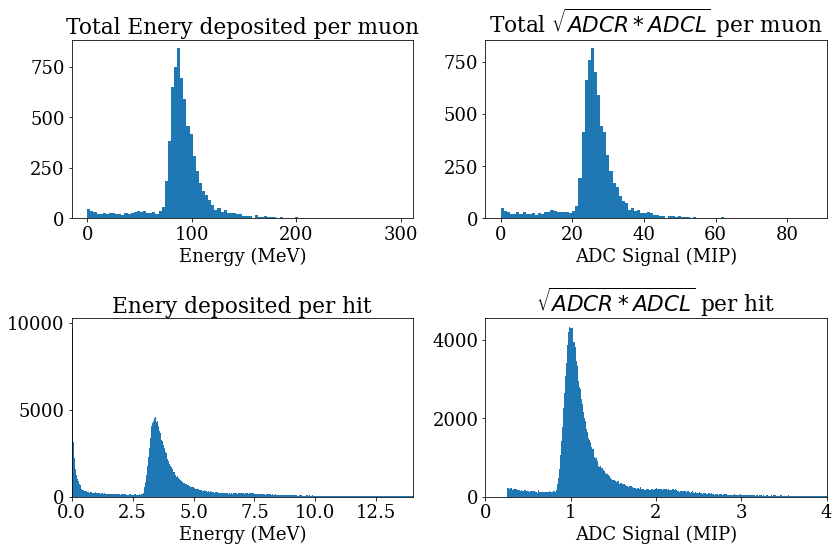

Time: 13.53


In [7]:
toc = time.perf_counter()
fig,ax = plt.subplots(2,2,figsize=(12,8))

ax[0][0].hist(totEdep,100)
ax[0][0].set_title("Total Enery deposited per muon")
ax[0][0].set_xlabel("Energy (MeV)")
#ax[0][0].set_ylim(0,170)

ax[0][1].hist(totADC/MIP,100)
ax[0][1].set_title("Total $\sqrt{ADCR*ADCL}$ per muon")
ax[0][1].set_xlabel("ADC Signal (MIP)")
#ax[0][1].set_ylim(0,170)

ax[1][0].hist(ak.flatten(Edeps),2000)
ax[1][0].set_title("Enery deposited per hit")
ax[1][0].set_xlabel("Energy (MeV)")
ax[1][0].set_xlim(0,max(ak.flatten(Edeps))//5)
#ax[1][0].set_ylim(0,20000)

ax[1][1].hist(ak.flatten(ADCs)/MIP,2000)
ax[1][1].set_xlabel("ADC Signal (MIP)")
ax[1][1].set_title("$\sqrt{ADCR*ADCL}$ per hit")
ax[1][1].set_xlim(0,max(ak.flatten(ADCs)/MIP)//5)
#ax[1][1].vlines(1,ymin=0,ymax=17500, color='r')
#ax[1][1].set_ylim(0,20000)
plt.show()
tic = time.perf_counter()
print(f"Time: {tic-toc:.2f}")

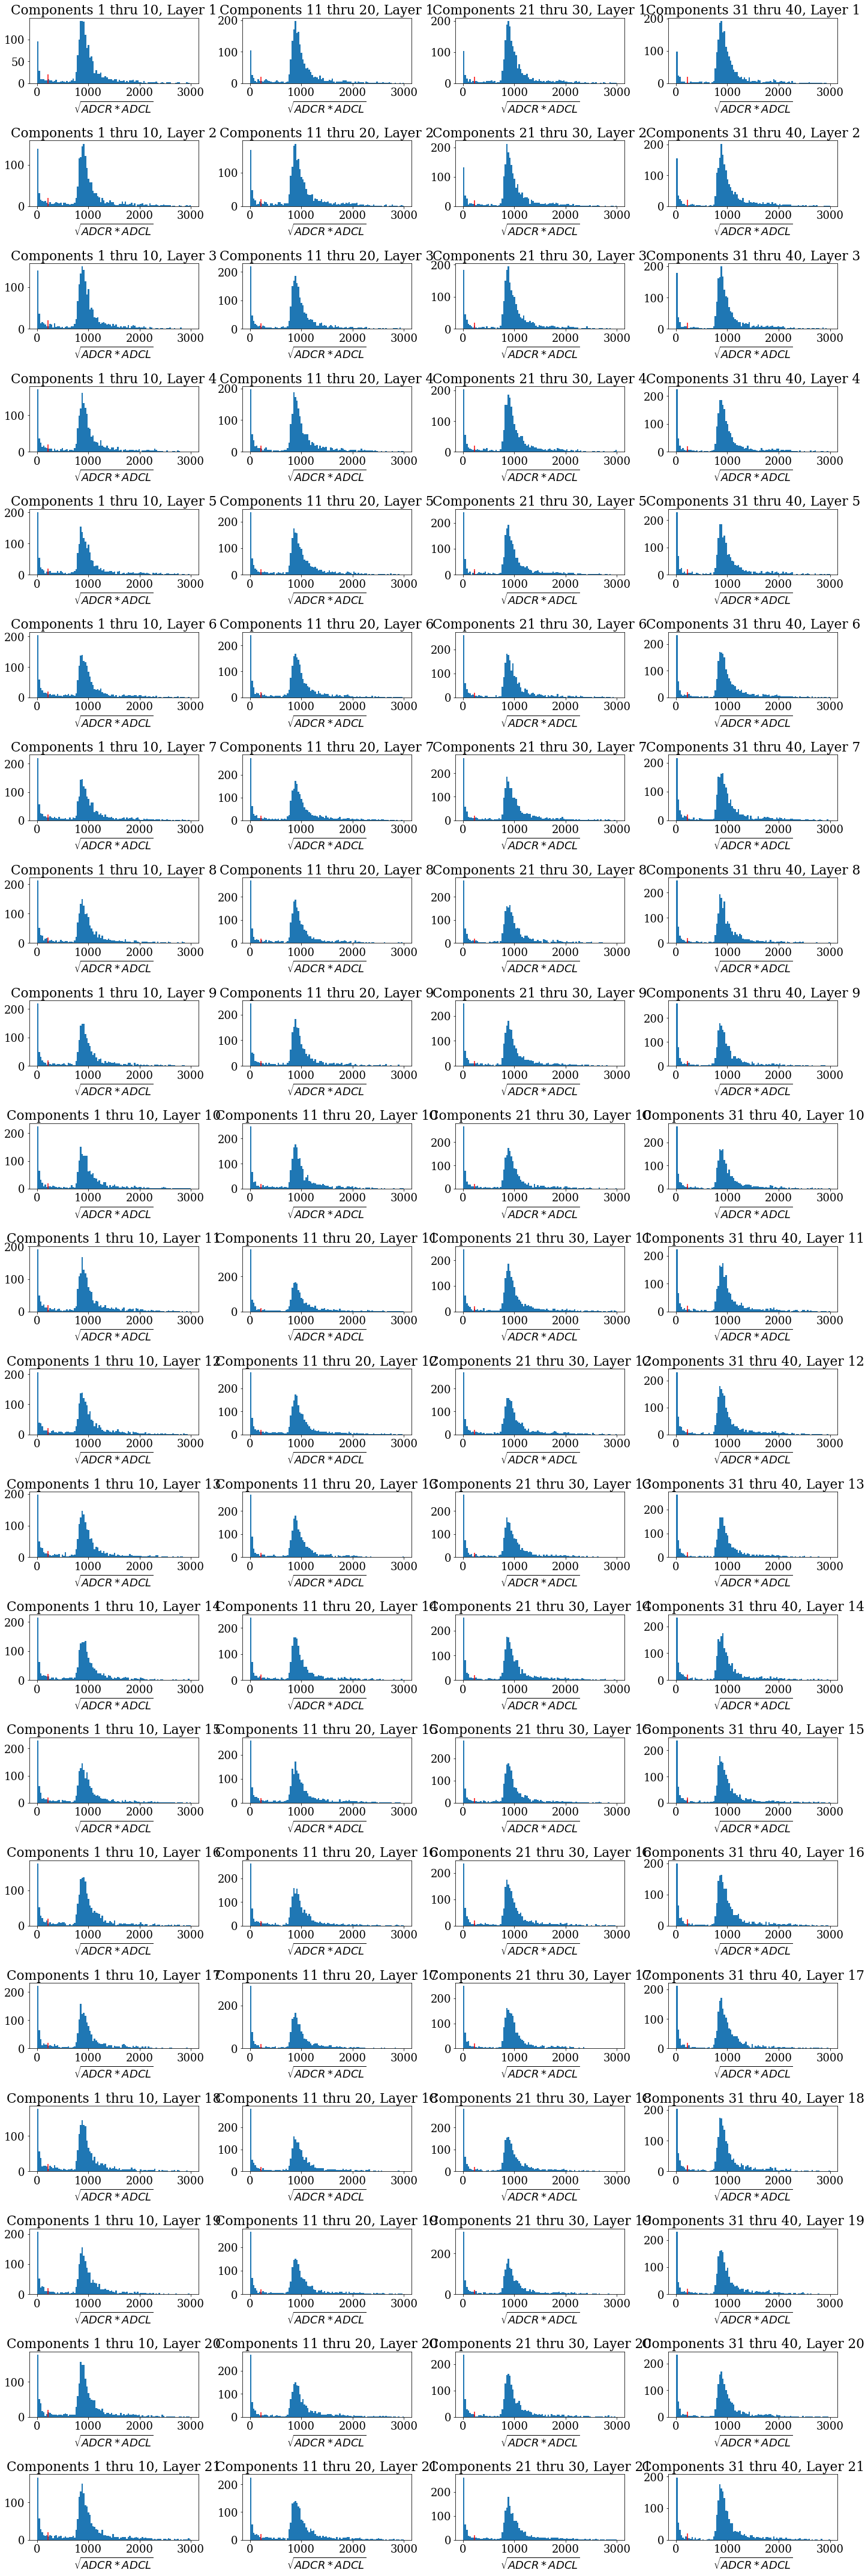

Time: 42.28


In [9]:
toc = time.perf_counter()
fig,ax = plt.subplots(21,4,figsize=(20,60))
counts = []
bincenters = []
for i in range(21):
    cut = ((components == 1) | (components == 2) | (components == 3) | (components == 4) | (components == 5) | (components == 6) | (components == 7) | (components == 8) | (components == 9) | (components == 10)) & (layers == i+1)
    ADC1s = np.sqrt(ak.flatten(ADCR_vals[cut]*ADCL_vals[cut]))
    ax[i][0].set_title(f"Components 1 thru 10, Layer {i+1}")
    count,binedge,bars = ax[i][0].hist(ADC1s,bins=100,range=(0,3000))
    bincenter = (binedge[:-1] + binedge[1:]) / 2.0
    counts.append(count)
    bincenters.append(bincenter)
    ax[i][0].vlines(minGeoMean,ymin=0,ymax=20, color='r')
    ax[i][0].set_xlabel("$\sqrt{ADCR*ADCL}$")
    
    cut = ((components == 11) | (components == 12) | (components == 13) | (components == 14) | (components == 15) | (components == 16) | (components == 17) | (components == 18) | (components == 19) | (components == 20)) & (layers == i+1)
    ADC10s = np.sqrt(ak.flatten(ADCR_vals[cut]*ADCL_vals[cut]))
    ax[i][1].set_title(f"Components 11 thru 20, Layer {i+1}")
    count,binedge,bars = ax[i][1].hist(ADC10s,bins=100,range=(0,3000))
    bincenter = (binedge[:-1] + binedge[1:]) / 2.0
    counts.append(count)
    bincenters.append(bincenter)
    ax[i][1].vlines(minGeoMean,ymin=0,ymax=20, color='r')
    ax[i][1].set_xlabel("$\sqrt{ADCR*ADCL}$")
    
    cut = ((components == 21) | (components == 22) | (components == 23) | (components == 24) | (components == 25) | (components == 26) | (components == 27) | (components == 28) | (components == 29) | (components == 30)) & (layers == i+1)
    ADC20s = np.sqrt(ak.flatten(ADCR_vals[cut]*ADCL_vals[cut]))
    ax[i][2].set_title(f"Components 21 thru 30, Layer {i+1}")
    count,binedge,bars = ax[i][2].hist(ADC20s,bins=100,range=(0,3000))
    bincenter = (binedge[:-1] + binedge[1:]) / 2.0
    counts.append(count)
    bincenters.append(bincenter)
    ax[i][2].vlines(minGeoMean,ymin=0,ymax=20, color='r')
    ax[i][2].set_xlabel("$\sqrt{ADCR*ADCL}$")
    
    cut = ((components == 31) | (components == 32) | (components == 33) | (components == 34) | (components == 35) | (components == 36) | (components == 37) | (components == 38) | (components == 39) | (components == 40)) & (layers == i+1)
    ADC30s = np.sqrt(ak.flatten(ADCR_vals[cut]*ADCL_vals[cut]))
    ax[i][3].set_title(f"Components 31 thru 40, Layer {i+1}")
    count,binedge,bars = ax[i][3].hist(ADC30s,bins=100,range=(0,3000))
    bincenter = (binedge[:-1] + binedge[1:]) / 2.0
    counts.append(count)
    bincenters.append(bincenter)
    ax[i][3].vlines(minGeoMean,ymin=0,ymax=20, color='r')
    ax[i][3].set_xlabel("$\sqrt{ADCR*ADCL}$")

plt.show()
tic = time.perf_counter()
print(f"Time: {tic-toc:.2f}")

In [8]:
#trim cut data
for countlist in range(len(counts)):
    for i in range(len(counts[countlist])):
        if i<findindex(bincenters[countlist],700): counts[countlist][i]=0
#print(counts[0],counts[1])

NameError: name 'counts' is not defined

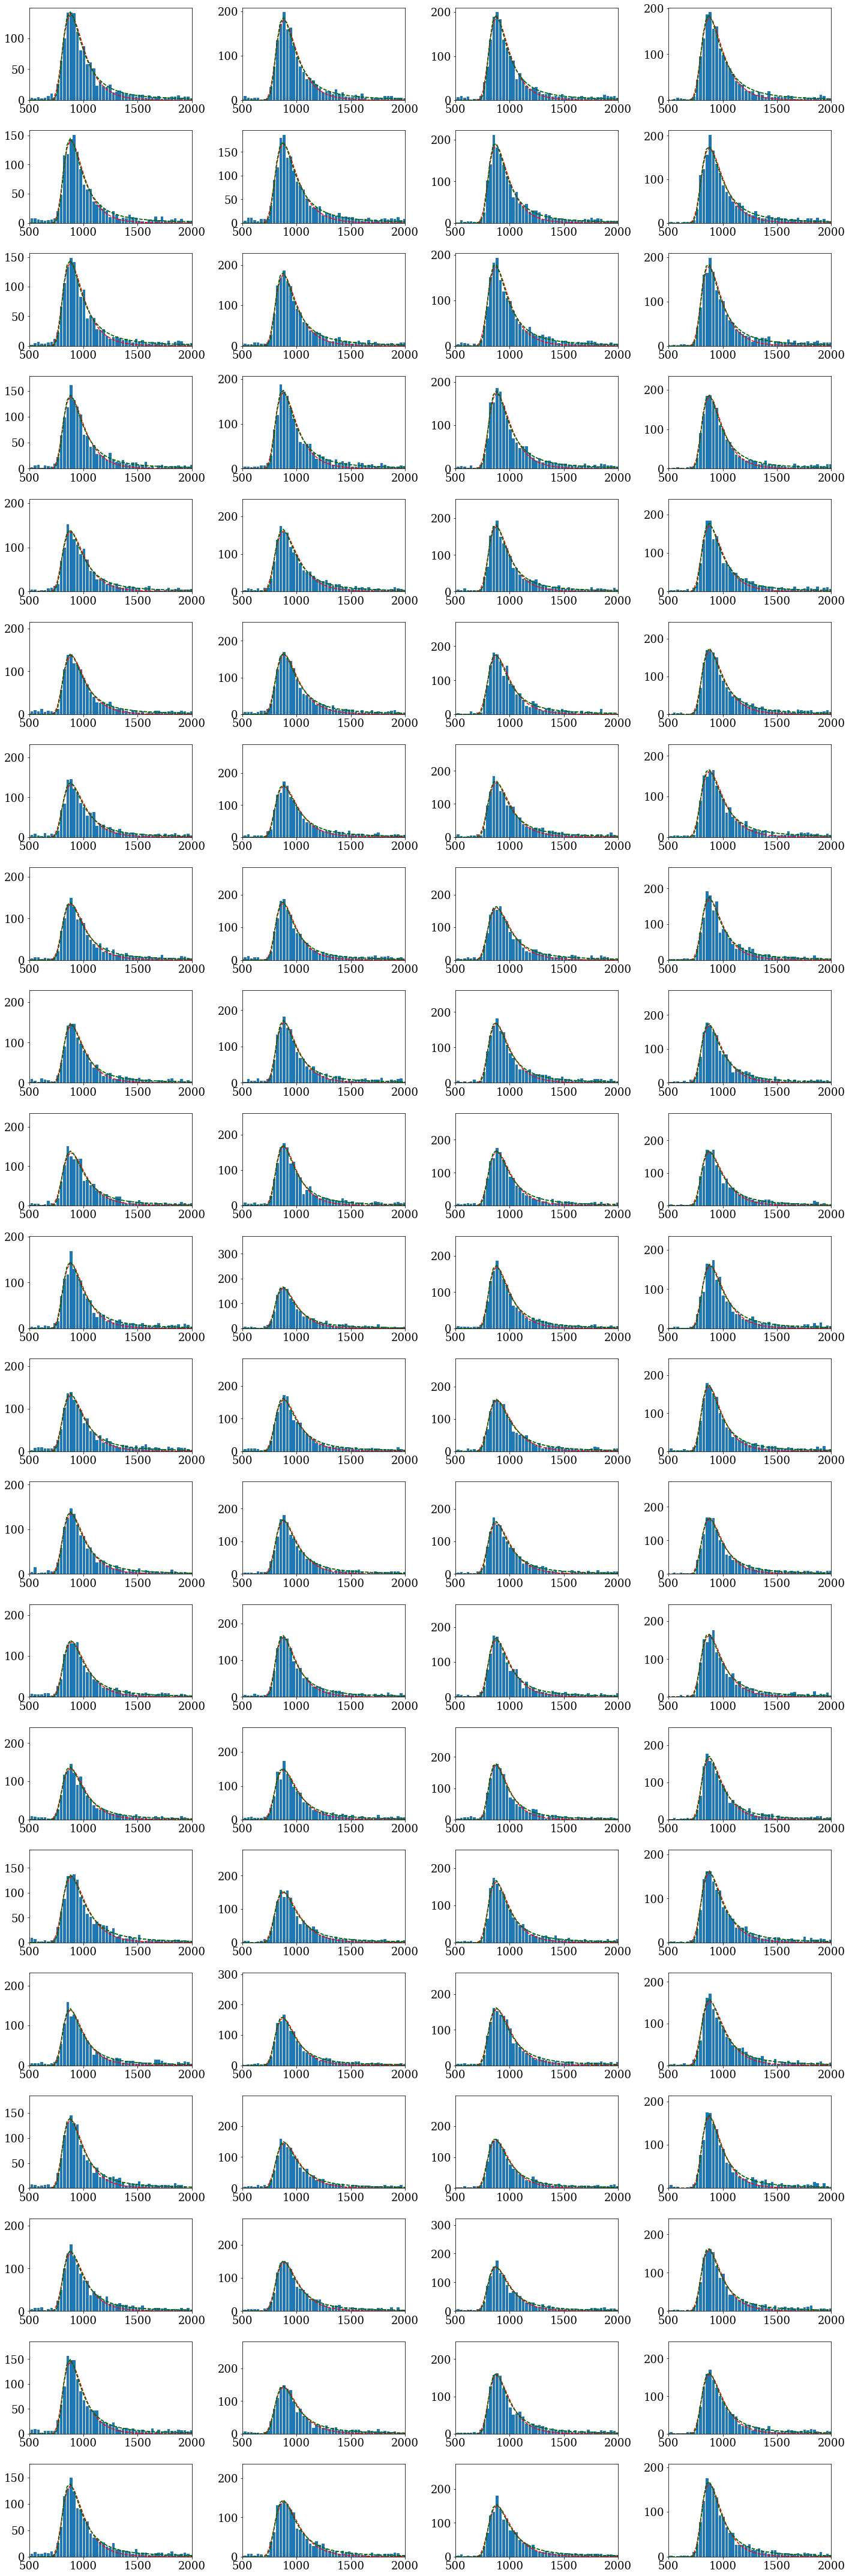

In [10]:
#counts=np.zeros((21,2))
#counts[0,1] = 2
#print(binedges[0],bincenters[0],counts[0])
xs = np.linspace(0,3000, 100)
params=np.array((21,3))
fig,ax = plt.subplots(21,4,figsize=(20,60))
from scipy.optimize import curve_fit
params = {a:[] for a in "location width normalization location2 width2 normalization2 location3 width3 normalization3".split()} # 

for countlist in range(len(counts)):
    print(f"Fit Number {countlist+1}",end="\r")
    ys=[]
    ys2=[]
    ys3=[]
    popt, pcov = curve_fit(Landau, bincenters[countlist], counts[countlist], p0=[880, 260, 160], maxfev=100000)#, ,sigma=np.sqrt(counts[countlist])/1000
    popt2, pcov2 = curve_fit(Landau2, bincenters[countlist], counts[countlist], p0=[885, 220, 160],maxfev=100000)#, sigma=np.sqrt(counts[countlist])
    popt3, pcov3 = curve_fit(Landau2, bincenters[countlist], counts[countlist], p0=[850, 400, 170],maxfev=100000)#, sigma=np.sqrt(counts[countlist])
    for x in xs:
        ys.append(Landau(x,popt[0],popt[1],popt[2]))
        ys2.append(Landau2(x,popt2[0],popt2[1],popt2[2]))
        ys3.append(Landau2(x,popt3[0],popt3[1],popt3[2]))
    #ys.append(Landau(xs, *popt))
    #print(*popt)
    params["location"].append(popt[0])
    params["width"].append(popt[1])
    params["normalization"].append(popt[2])
    params["location2"].append(popt2[0])
    params["width2"].append(popt2[1])
    params["normalization2"].append(popt2[2])
    params["location3"].append(popt3[0])
    params["width3"].append(popt3[1])
    params["normalization3"].append(popt3[2])
    
    ax[countlist//4][countlist%4].bar(bincenters[countlist],counts[countlist],25)
    ax[countlist//4][countlist%4].plot(xs,ys,color="red",linestyle="--")
    ax[countlist//4][countlist%4].plot(xs,ys2,color="black",linestyle="--")
    ax[countlist//4][countlist%4].plot(xs,ys3,color="green",linestyle="--")
    ax[countlist//4][countlist%4].set_xlim(500,2000)

    
paramdf = pd.DataFrame(params)

In [11]:
maxs = []
maxs2=[]
xs = np.linspace(855,875,1001)
for i in range(len(paramdf.location2)):
    landau2s = []
    for x in xs:
        landau2s.append(Landau2(x,paramdf.location2[i],paramdf.width2[i],paramdf.normalization2[i]))
    xmax,ymax = findmax(xs,landau2s,855,875)
    maxs.append(xmax)
for i in range(len(paramdf.location3)):
    landau2s = []
    for x in xs:
        landau2s.append(Landau2(x,paramdf.location3[i],paramdf.width3[i],paramdf.normalization3[i]))
    xmax,ymax = findmax(xs,landau2s,855,875)
    maxs2.append(xmax)

#

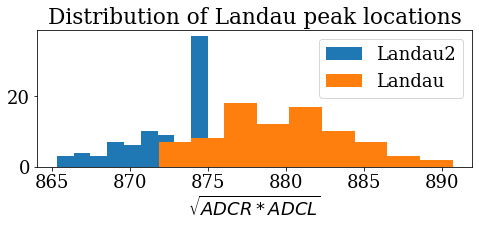

In [12]:

count,bins,bars=plt.hist(maxs,9,label="Landau2")
plt.hist(paramdf.location,9,label="Landau")
#plt.hist(maxs2,9,label="Landau22")
plt.title("Distribution of Landau peak locations")
plt.xlabel(f"$\sqrt{{ADCR*ADCL}}$")
plt.legend()
#plt.xlabel(f"$x_{{{sigtype}}}-x_{{\\rm truth}}$ [mm]")
#params=np.array((21,3))
#paramdf

In [153]:
MIP1 = np.mean((paramdf.location))
MIP1u = np.std((paramdf.location))
MIP2 = np.mean((maxs))
MIP2u = np.std((maxs))
MIP = np.average([MIP1,MIP2],weights=[1/MIP1u,1/MIP2u])#(MIP1*MIP1u+MIP2*MIP2u)/(MIP1u+MIP2u)
print(f"MIP conversion factor: {MIP:.2f} ± {np.sqrt(MIP1u**2+MIP2u**2):.2f}")

MIP conversion factor: 876.37 ± 4.52


In [186]:
flatlay = ak.flatten(layers)
flatx = ak.flatten(avg_xs)


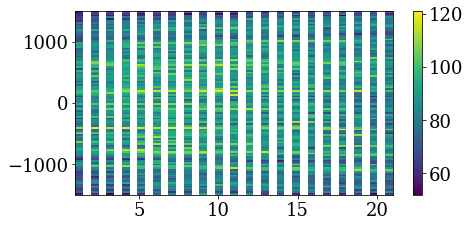

In [190]:
plt.hist2d(np.array(flatlay),np.array(flatx),cmin=1,bins=(41,100))
plt.colorbar()
plt.show()

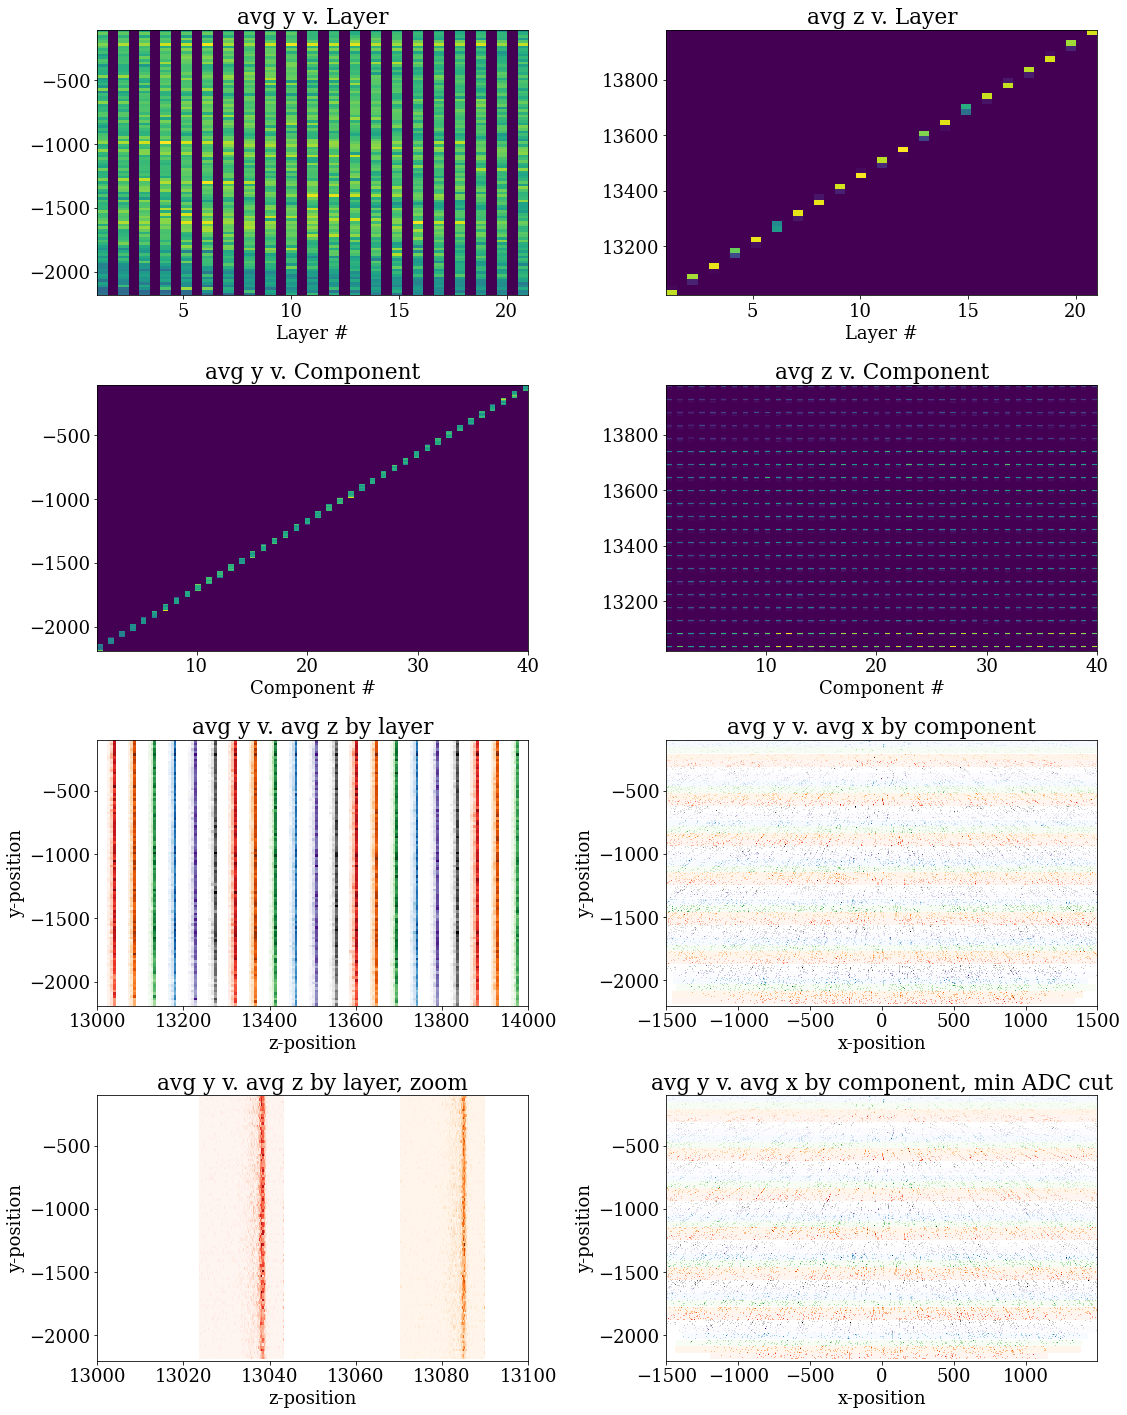

In [211]:
fig,ax = plt.subplots(4,2,figsize=(16,20))



ax[0][0].set_title(f"avg y v. Layer")
ax[0][0].set_xlabel("Layer #")
ax[0][0].hist2d(np.array(ak.flatten(layers)),np.array(ak.flatten(avg_ys)), bins=(41, 100))
#ax[0][0].set_ylim(-500,-100)
ax[0][1].set_title(f"avg z v. Layer")
ax[0][1].set_xlabel("Layer #")
ax[0][1].hist2d(np.array(ak.flatten(layers)),np.array(ak.flatten(avg_zs)), bins=(41, 50))

ax[1][0].set_title(f"avg y v. Component")
ax[1][0].set_xlabel("Component #")
ax[1][0].hist2d(np.array(ak.flatten(components)),np.array(ak.flatten(avg_ys)), bins=(79, 1000))
#ax[1][0].set_ylim(-500,-100)
ax[1][0].set_xlim(1,40)
ax[1][1].set_xlabel("Component #")
ax[1][1].set_title(f"avg z v. Component")
ax[1][1].hist2d(np.array(ak.flatten(components)),np.array(ak.flatten(avg_zs)), bins=(79, 1000))

ax[1][1].set_xlim(1,40)

cols=["Reds","Oranges","Greens","Blues","Purples","Greys"]
ax[2][0].set_title(f"avg y v. avg z by layer")
for i in range(21):
    ax[2][0].hist2d(np.array(ak.flatten(avg_zs[layers==i+1])),np.array(ak.flatten(avg_ys[layers==i+1])), bins=(3, 100),cmap=f"{cols[i%6]}")

ax[2][0].set_xlim(13000,14000)
#ax[2][0].set_ylim(-500,-100)
ax[2][0].set_xlabel("z-position")
ax[2][0].set_ylabel("y-position")

ax[2][1].set_title(f"avg y v. avg x by component")
for i in range(40):
    ax[2][1].hist2d(np.array(ak.flatten(avg_xs[components==i+1])),np.array(ak.flatten(avg_ys[components==i+1])), bins=(3000, 10),cmap=f"{cols[i%6]}")
#ax[2][1].set_xlim(-30,30)
ax[2][1].set_ylim(-2200,-100)
ax[2][1].set_xlabel("x-position")
ax[2][1].set_ylabel("y-position")

cols=["Reds","Oranges","Greens","Blues","Purples","Greys"]
ax[3][0].set_title(f"avg y v. avg z by layer, zoom")
for i in range(21):
    ax[3][0].hist2d(np.array(ak.flatten(avg_zs[layers==i+1])),np.array(ak.flatten(avg_ys[layers==i+1])), bins=(80, 100),cmap=f"{cols[i%6]}")

ax[3][0].set_xlim(13000,13100)
ax[3][0].set_ylim(-2200,-100)
ax[3][0].set_xlabel("z-position")
ax[3][0].set_ylabel("y-position")

ax[3][1].set_title(f"avg y v. avg x by component, min ADC cut")
for i in range(40):
    ax[3][1].hist2d(np.array(ak.flatten(avg_xs[(components==i+1) & MIPcut])),np.array(ak.flatten(avg_ys[(components==i+1) & MIPcut])), bins=(3000, 10),cmap=f"{cols[i%6]}")
#ax[3][1].set_xlim(-30,30)
ax[3][1].set_ylim(-2200,-100)
ax[3][1].set_xlabel("x-position")
ax[3][1].set_ylabel("y-position")

plt.show()

## Now determine the correlations between the hit x position and the TDCR-TDCL and also between x and the log(ADCL/ADCR)

The x position of the hits then can be reconstructed using either the TDC or the ADC.  

m,b= 0.5589837724509396 -0.01041965845052714


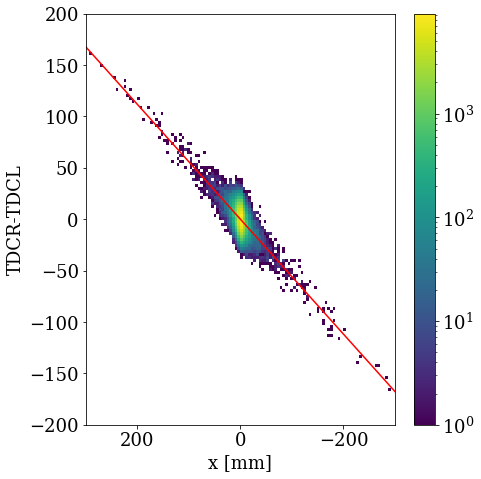

mu, sigma = 4.947365053828711e-16, 15.441038550954135


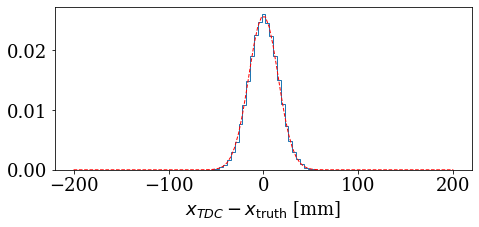

m,b= 0.000992504142070655 0.000196705241689167


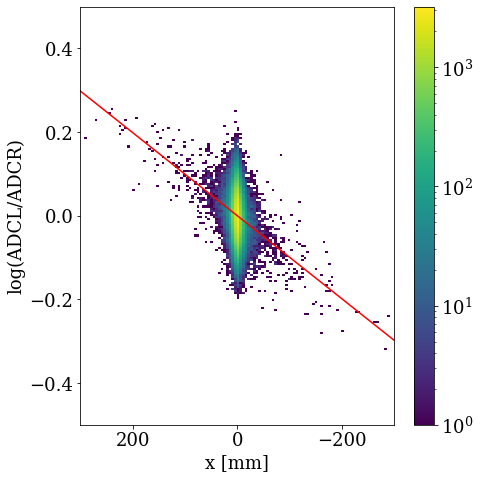

mu, sigma = 0.01134537138183612, 46.27741207145281


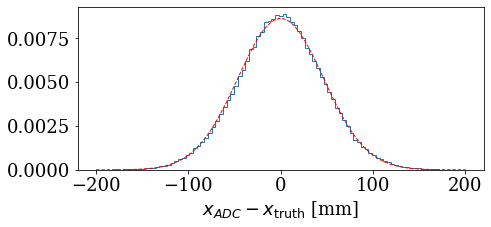

In [54]:
results =[]
for sigtype,label, formula in (("TDC","TDCR-TDCL","TDCR-TDCL"), 
                    ("ADC","log(ADCL/ADCR)","log(ADCL/ADCR)")):
    q="sqrt(ADCR*ADCL)>500"
    x=ak.flatten(avg_xs)
    obs=df.query(q).eval(formula)
    m= (len(x)*np.sum(x*obs)-np.sum(x)*np.sum(obs))/(len(x)*np.sum(x*x)-np.sum(x)*np.sum(x))
    b = np.sum(obs-m*x)/len(x)
    print("m,b=", m, b)
    fig, axs = plt.subplots(1,1,figsize=(7,7))
    plt.hist2d(df.query(q).avg_x,df.query(q).eval(formula),bins=[500,500],cmin=1,norm=mpl.colors.LogNorm())
    if sigtype=="TDC":
        plt.xlim(-300,300)
        plt.ylim(-200,200)
    elif sigtype=="ADC":
        plt.xlim(-300,300)
        plt.ylim(-0.5,0.5)
    plt.colorbar()
    #plt.plot(x[:], obs[:], marker='.', linestyle="")
    xpt = pd.Series([-1500, 1500])
    #plt.xlim(-.2,.2)
    plt.plot(xpt, m*xpt+b, linestyle="-",color="red")
    plt.gca().invert_xaxis()
    plt.xlabel("x [mm]")
    plt.ylabel(label)
    plt.show()
    
    #now create a residual plot
    from scipy.stats import norm
    import matplotlib.mlab as mlab
    residuals= x-(obs-b)/m
    (mu, sigma) = norm.fit(residuals[abs(residuals)<150])
    print(f"mu, sigma = {mu}, {sigma}")
    # the histogram of the data
    n, bins, patches = plt.hist(residuals, bins=np.linspace(-200, 200, 100), 
                            histtype='step',density=True)
    # add a 'best fit' line
    y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
    l = plt.plot(bins, y, 'r--', linewidth=1)

    plt.xlabel(f"$x_{{{sigtype}}}-x_{{\\rm truth}}$ [mm]")
    plt.show()
    results.append({"formula": formula, "m":m, "b":b, "sigma":sigma, "mu":mu})

## now combine both types of x reconstruction methods

{'formula': 'TDCR-TDCL', 'm': 0.5589837724509396, 'b': -0.01041965845052714, 'sigma': 15.441038550954135, 'mu': 4.947365053828711e-16}
{'formula': 'log(ADCL/ADCR)', 'm': 0.000992504142070655, 'b': 0.000196705241689167, 'sigma': 46.27741207145281, 'mu': 0.01134537138183612}


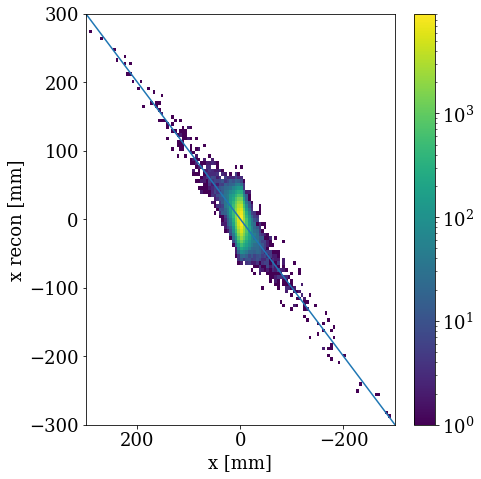

mu, sigma =  2.560351695740552e-16 15.313674428777947


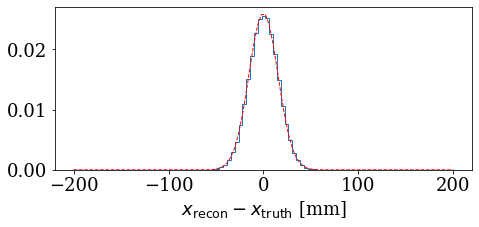

In [66]:

from scipy.stats import norm
import matplotlib.mlab as mlab

num = 0
denom = 0
for result in results:
    print(result)
    weight = 1/result['sigma']**2
    num = num+(df.query(q).eval(result['formula'])-result['b'])/result['m']*weight
    denom = denom+weight
    
x_recon = num/denom

fig, axs = plt.subplots(1,1,figsize=(7,7))
plt.hist2d(x[:],x_recon[:],bins=[500,500],cmin=1,norm=mpl.colors.LogNorm())
plt.colorbar()
plt.xlim(-300,300)
plt.ylim(-300,300)
#plt.plot(x[:], x_recon[:], marker='.', linestyle="")
xpt = pd.Series([-1500, 1500])
#plt.xlim(-.2,.2)
plt.plot(xpt, xpt, linestyle="-")
plt.gca().invert_xaxis()
plt.xlabel("x [mm]")
plt.ylabel("x recon [mm]")
plt.show()

residuals= x-x_recon
(mu, sigma) = norm.fit(residuals[abs(residuals)<150])
# the histogram of the data
n, bins, patches = plt.hist(residuals, bins=np.linspace(-200, 200, 100), 
                        histtype='step',density=True)
# add a 'best fit' line
y = 1/(np.sqrt(2*np.pi)*sigma)*np.exp(-(bins-mu)**2/(2*sigma**2))
l = plt.plot(bins, y, 'r--', linewidth=1)

plt.xlabel("$x_{\\rm recon}-x_{\\rm truth}$ [mm]")

print("mu, sigma = ", mu, sigma)

## now look at the total time resolution

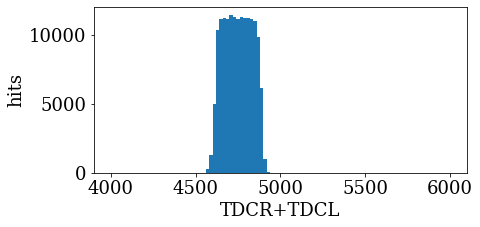

In [48]:
plt.hist(df.query(q).eval("TDCL+TDCR"), bins=100, range=(4000, 6000))
plt.xlabel("TDCR+TDCL")
plt.ylabel("hits")
plt.show()

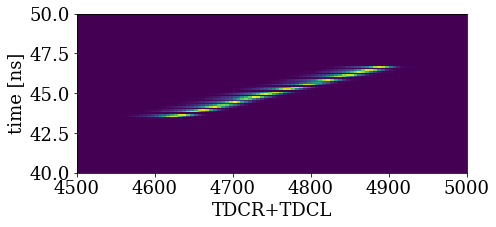

In [49]:
plt.hist2d(df.query(q).eval("TDCL+TDCR"), df.query(q).eval("avg_t"), 
           bins=100, range=((4500, 5000),(40, 50)))
plt.xlabel("TDCR+TDCL")
plt.ylabel("time [ns]")
plt.show()